In [1]:
import tensorflow as tf
import torch 
import Bio.SeqIO as SeqIO
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import tqdm
import pandas as pd
from sklearn.metrics import recall_score
from utils.BERT_utils import *
from utils.TFBS_utils import *
from utils.CNN_utils import *

2024-02-04 10:04:16.259750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-04 10:04:16.902587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the trained Hybrid NN

In [2]:
# Load the models
all_seq_NN = tf.keras.models.load_model('/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/NN/all_length_cnn_lstm.h5') 

2024-01-20 11:02:34.518202: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Load the finetuned DNABERT model

In [3]:

KMER = 6
STRIDE_SIZE = 1

tokenizer = BertTokenizer.from_pretrained(f'zhihan1996/DNA_bert_6')
model = BertForSequenceClassification.from_pretrained("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT/LTRBERT_lineage_512")
model.eval()

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
model.to(device)


## Load the trained RF classifier

In [2]:
import pickle
GBC = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/TFBS/GBC_pipeline.b", "rb"))

## Test on short sequences (within 512bps)

In [3]:

MAX_LEN=512
MIN_LEN=0

n_classes = 15
LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
n_sequences = len(LTRs)


d = pd.DataFrame({"seq_id": [rec.id for rec in LTRs], 'sequence':[str(rec.seq) for rec in LTRs], 'label':[rec.description.split(" ")[4] for rec in LTRs]})

d = d[~d['label'].str.contains("copia")]
d = d[d["label"].isin(d["label"].value_counts()[:n_classes].index.tolist())]

In [4]:
import pickle

label_encoder = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/label_encoder.b", "rb"))
encoded_labels = label_encoder.transform(d['label'])
#sequences = [onehote(str(rec.seq)) for rec in tqdm.tqdm(LTRs)] + [onehote(str(rec.seq)) for rec in tqdm.tqdm(non_LTRs)]

/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### LTRBERT
- tokenize
- encode
- run predictions

In [45]:
from transformers import Trainer
sequences = d["sequence"]

data = Dataset(tokenizer([tok_func(x, int(KMER), STRIDE_SIZE) for x in sequences], padding=True, truncation=True, max_length=512), encoded_labels)
trainer = Trainer(model)
raw_pred, _, _ = trainer.predict(data) # Preprocess raw predictions
BERT_short_predictions = np.argmax(raw_pred, axis=1)

In [46]:
np.save("BERT_short_predictions.npy", BERT_short_predictions)
np.save("raw_pred.npy", raw_pred)

### CNN-LSTM
- encode
- pad
- run predictions

In [7]:
import numpy as np

def remove_N(seq):
    """
    Remove Ns from sequence
    """
    return seq.upper().replace("N", "")

def onehote(seq):
    """
    One Hot encoding function
    """
    seq2=list()
    mapping = {"A":[1., 0., 0., 0.], "C": [0., 1., 0., 0.], "G": [0, 0., 1., 0.], "T":[0., 0., 0., 1.], "N":[0., 0., 0., 0.]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0., 0., 0., 0.]) 
    return np.array(seq2)

In [ ]:
sequences = [onehote(remove_N(rec)) for rec in tqdm.tqdm(d["sequence"])]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding="pre", maxlen=3000)
pred_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_long_predictions = np.argmax(pred_probas, axis=1)

In [48]:
np.save("NN_short_predictions.npy", Hybrid_NN_long_predictions)
np.save("_NN_pred_probas.npy", pred_probas)

In [20]:
import numpy as np

# Specify the file path
raw_pred = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/pred_probas_BERT_short.npy")

pred_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/pred_probas_NN_short.npy")


## GBC

In [5]:
test_LTR_motifs = pickle.load(open("/data/xhorvat9/ltr_bert/Simple_ML_model/test_LTR_TFBS_old638.b", "rb"))

In [8]:
LTR_motif_dict_count = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
LTR_motif_dict_presence = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
get_presence_count_dict(LTR_motif_dict_count, LTR_motif_dict_presence, test_LTR_motifs)

IDs = list(test_LTR_motifs.keys())
LTR_dt = pd.DataFrame(LTR_motif_dict_count, index=IDs)

data = LTR_dt
data.index.name = "ID"

Match to sequence IDS below 512 bps

In [9]:
label_df = pd.DataFrame({"ID": [rec_id for rec_id in d["seq_id"]], "class" : encoded_labels})
label_df.index = label_df["ID"]

ltr_df = pd.DataFrame({"ID": [rec.id for rec in LTRs], "sequence" : [str(rec.seq) for rec in LTRs]}).set_index("ID")
ltr_df = ltr_df.join(label_df, how="inner")
ltr_df = ltr_df.drop("ID", axis=1)

sequences = ltr_df["sequence"].tolist()

In [10]:
data = data.join(ltr_df, how = "inner", on = "ID")#.drop("ID", axis=1)

Y = data["class"]
X = data.drop( ["sequence","class"], axis=1)

Y_short = Y

In [11]:
GBC_predictions = GBC.predict(X)
GBC_predict_probas = GBC.predict_proba(X)

In [12]:
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_predict_probas.npy", GBC_predict_probas)
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_predictions.npy", GBC_predictions)

## Evaluate on short sequences
- Accuracy
- Sensitivity
- Specificity
- MCC
- ROC-AUC
- confusion matrix

In [73]:
RFC_predictions = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/RFC_predictions.npy")
BERT_short_predictions = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_short_predictions.npy")
BERT_predict_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_predict_probas.npy")
NN_predict_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/_NN_pred_probas.npy")

In [27]:
Hybrid_NN_long_predictions = np.argmax(NN_predict_probas, axis=1)

In [30]:
recall_score

'BERT'

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Create a list of predictions and labels
Y =  encoded_labels
predictions = [RFC_predictions, Hybrid_NN_long_predictions, BERT_short_predictions]
names = ['RFC', 'Hybrid NN', 'BERT']

# Create a list to store the metrics
accuracy_list = []
sensitivity_list = []
specificity_list = []
mcc_list = []
roc_auc_list = []
f1_list = []
y=Y
# Calculate the metrics for each prediction

for pred, n in zip(predictions, names):
    report = classification_report(Y, pred)
    print(f"Classification Report for {n}:")
    print(report)
    print()

Classification Report for RFC:
              precision    recall  f1-score   support

           0       0.48      0.90      0.62      4741
           1       0.89      0.12      0.21       675
           2       0.50      0.36      0.42      1519
           3       1.00      0.08      0.15       384
           4       0.38      0.72      0.49      4081
           5       1.00      0.00      0.01       261
           6       1.00      0.03      0.06       625
           7       0.88      0.10      0.17      1335
           8       0.77      0.12      0.21      1393
           9       0.51      0.55      0.53      1360
          10       0.67      0.07      0.13       723
          11       1.00      0.02      0.04       586
          12       0.42      0.03      0.05       820
          13       0.41      0.33      0.36      1941
          14       0.74      0.12      0.21      1297

    accuracy                           0.45     21741
   macro avg       0.71      0.24      0.24     2

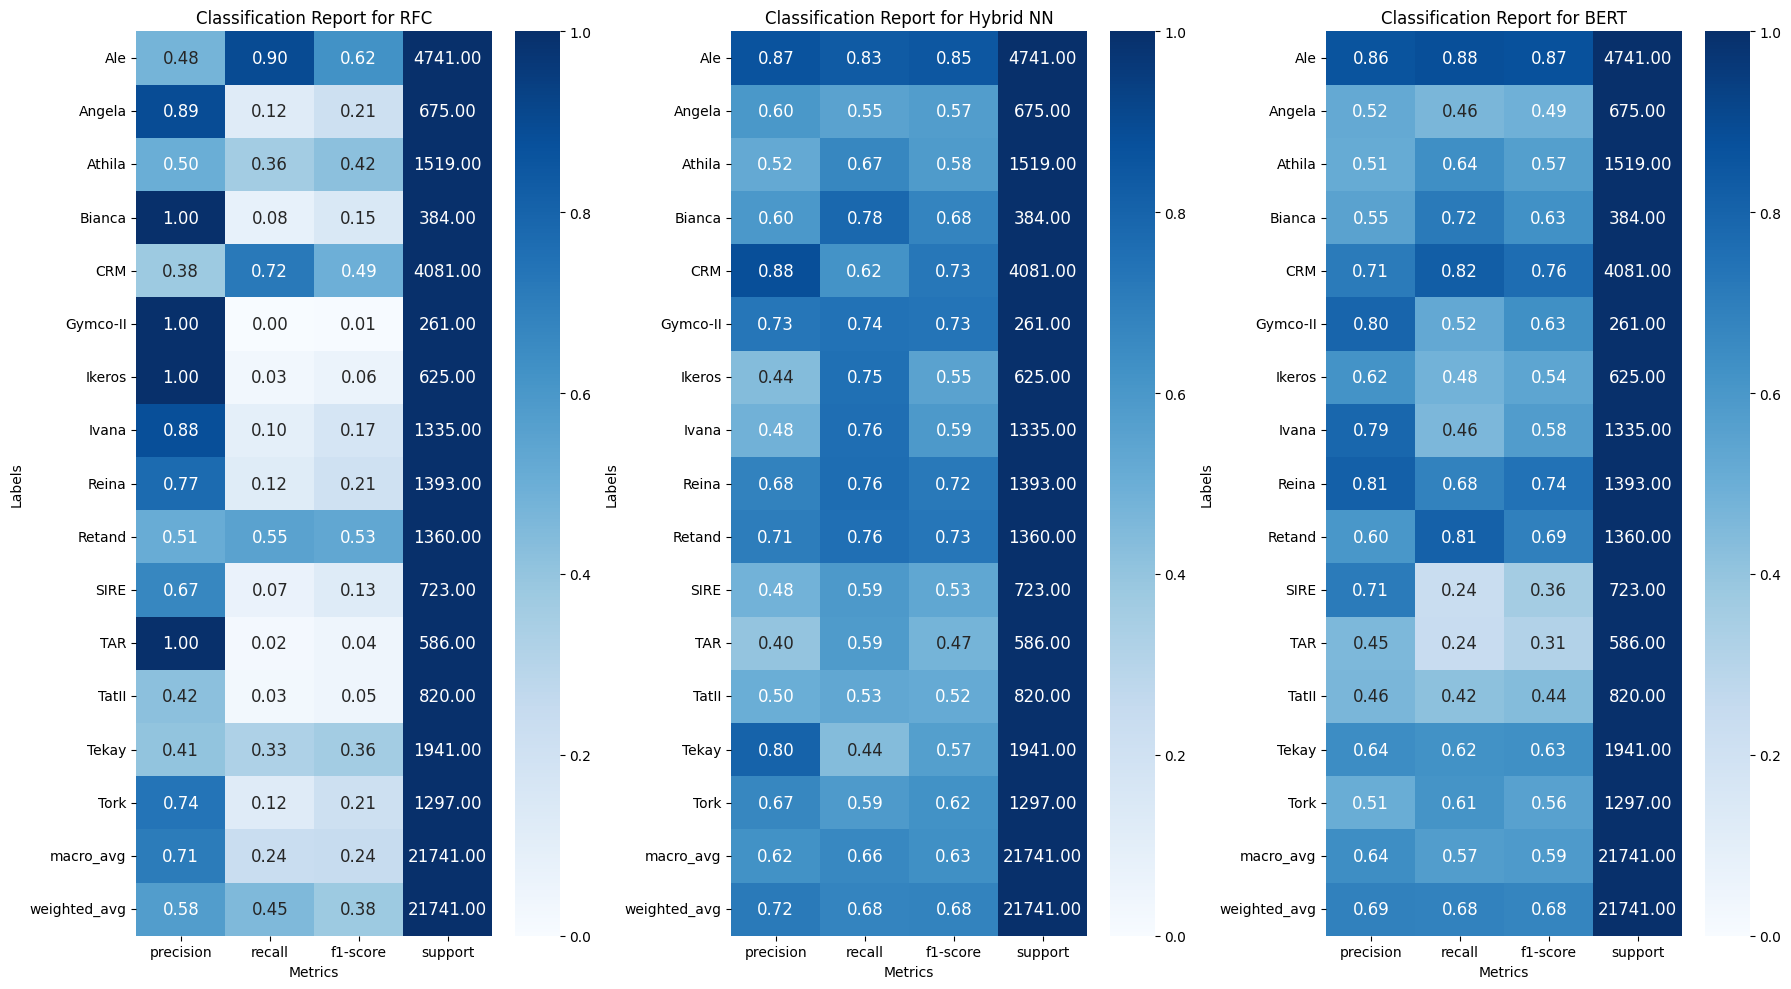

In [65]:
import seaborn as sns
from sklearn.metrics import classification_report

# Create a list of predictions and labels
predictions = [RFC_predictions, Hybrid_NN_long_predictions, BERT_short_predictions]
names = ['RFC', 'Hybrid NN', 'BERT']

# Create a list to store the classification reports
reports = []

# Generate the classification report for each prediction
for pred, name in zip(predictions, names):
    report = classification_report(Y, pred, output_dict=True)
    reports.append(report)

# Plot the classification reports
fig, axes = plt.subplots(1,len(reports), figsize=(6* len(reports), 10))

for i, report in enumerate(reports):
    rep = pd.DataFrame(report).drop("accuracy", axis=1)
    rep.columns = [label_encoder.inverse_transform([i])[0] for i in range(15)] + ["macro_avg", "weighted_avg"]
    rep = rep.T
    rep["support"] = rep["support"].astype(int)
    
    ax = axes[i]
    sns.heatmap(rep, annot=True, cmap="Blues", cbar=True, ax=ax, vmax=1, vmin=0, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title(f"Classification Report for {names[i]}")
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Labels')

plt.tight_layout()
plt.show()


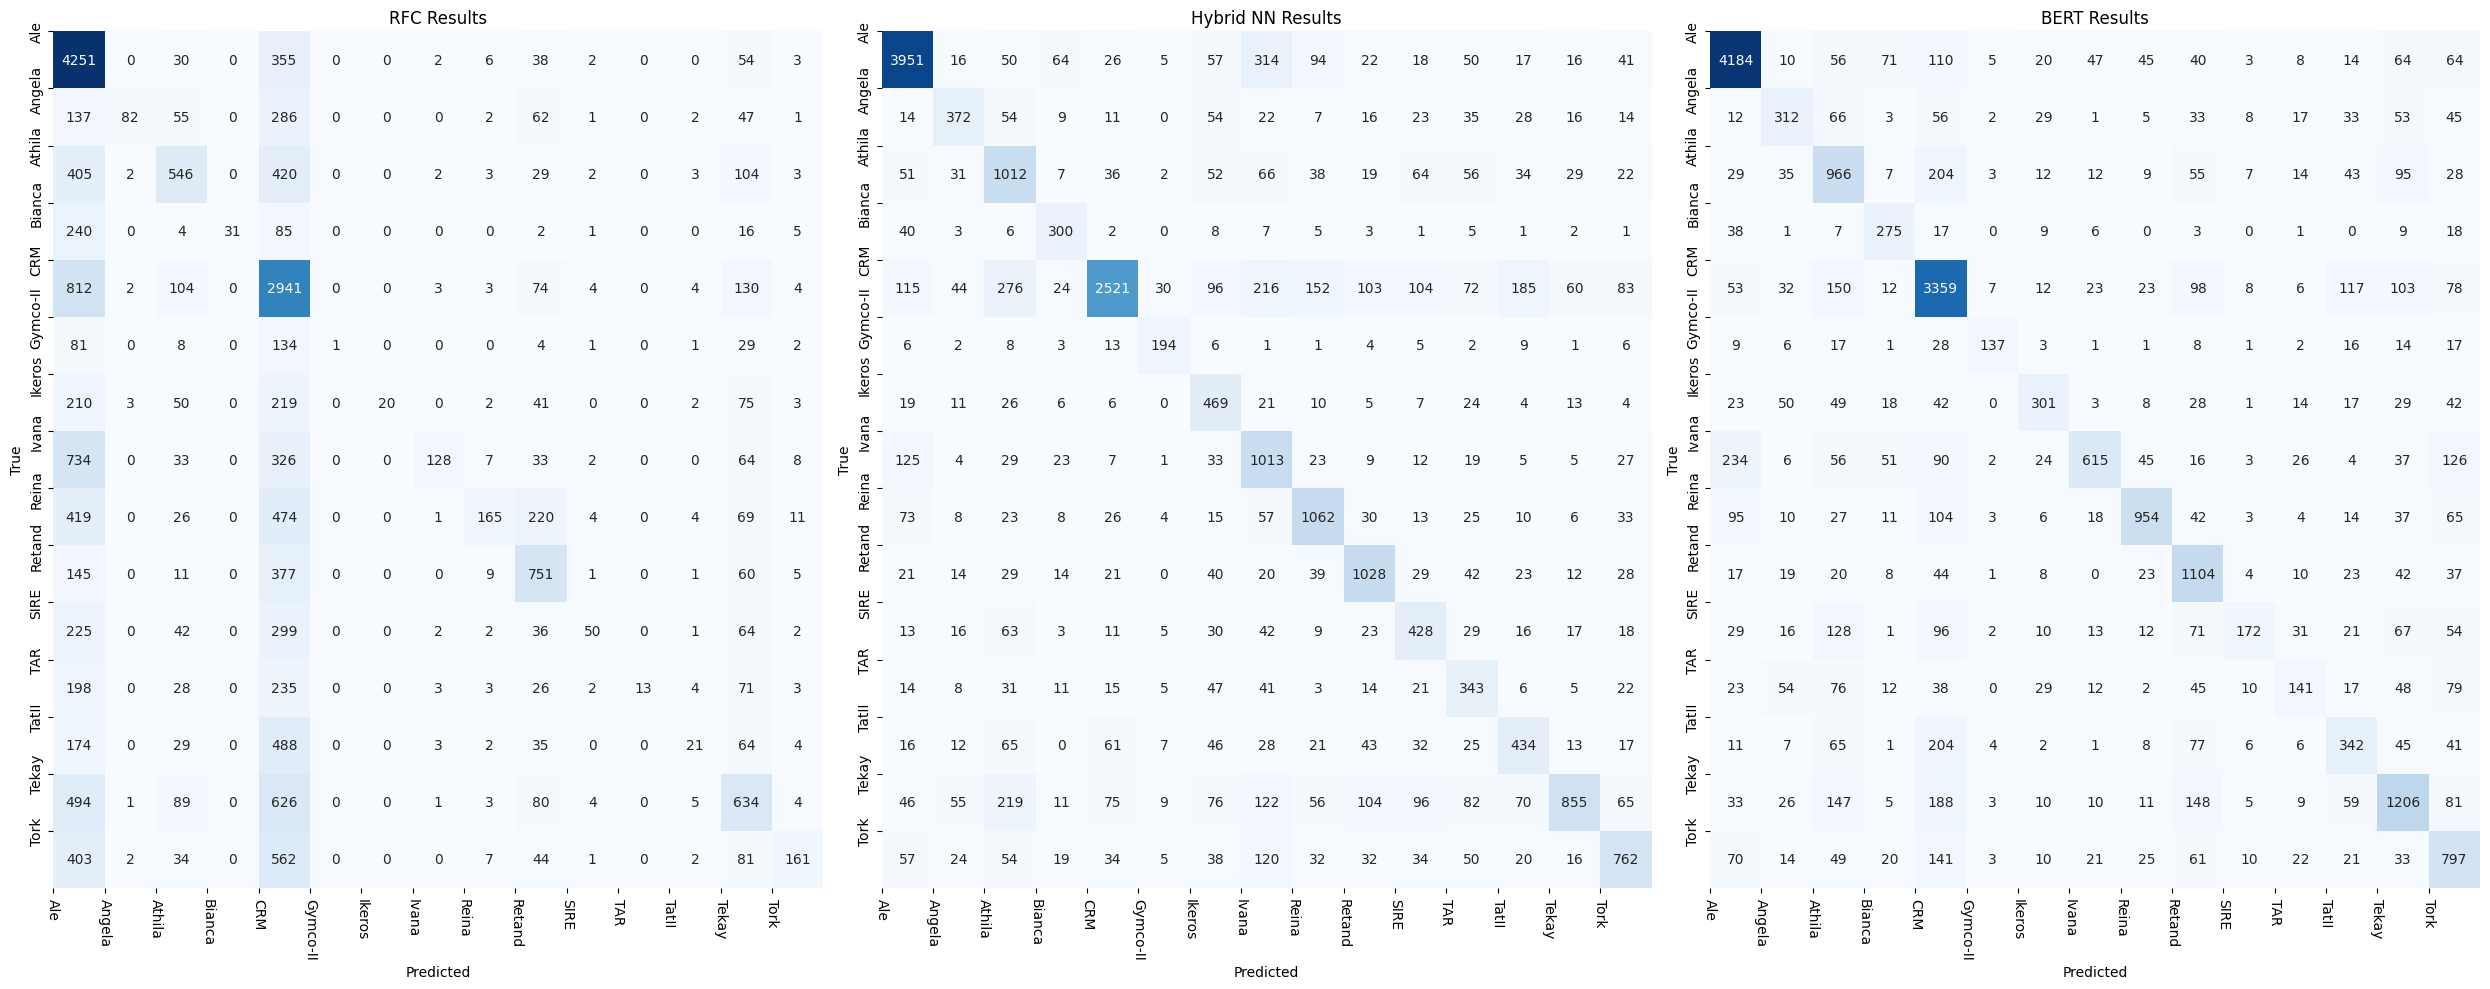

In [72]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Calculate confusion matrix
cm = confusion_matrix(Y, RFC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=4300, vmin=0)
axes[0].set_title('RFC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([i for i in range(15)])
axes[0].set_yticks([i for i in range(15)])
axes[0].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[0].set_yticklabels(label_encoder.classes_, rotation=90)


cm = confusion_matrix(Y, Hybrid_NN_long_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=4300, vmin=0)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([i for i in range(15)])
axes[1].set_yticks([i for i in range(15)])
axes[1].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[1].set_yticklabels(label_encoder.classes_, rotation=90)

# Calculate confusion matrix
cm = confusion_matrix(Y, BERT_short_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=4300, vmin=0)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([i for i in range(15)])
axes[2].set_yticks([i for i in range(15)])
axes[2].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[2].set_yticklabels(label_encoder.classes_, rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

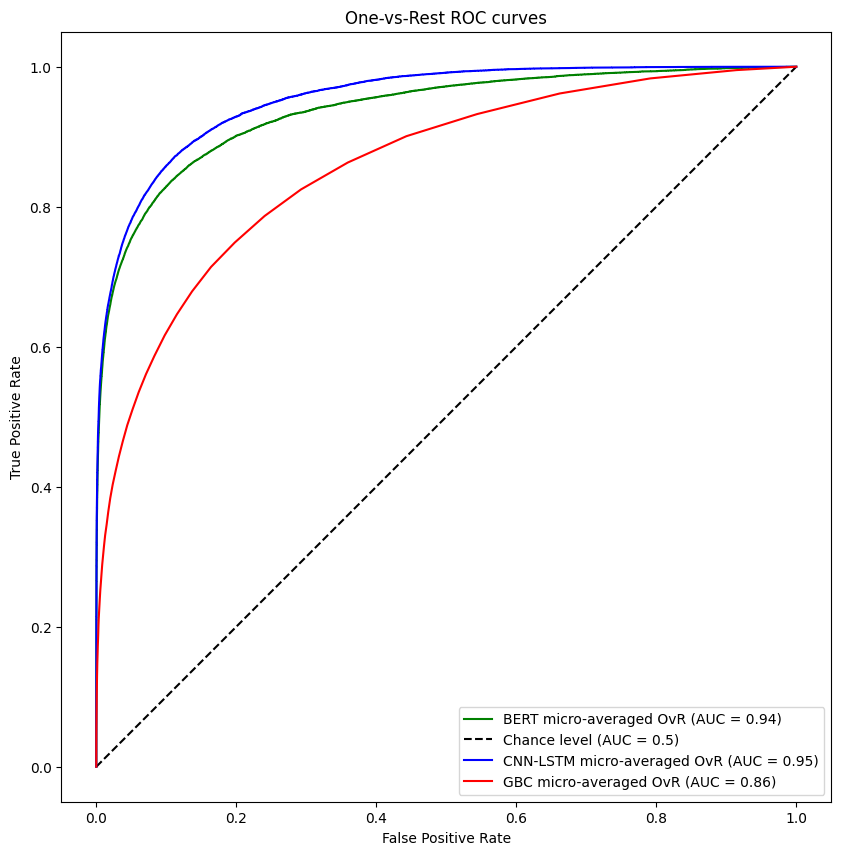

In [75]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit([i for i in range(n_classes)])
onehot_labels = lb.transform(Y)


fig, ax = plt.subplots(figsize=(10, 10))

roc_display1 =RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    BERT_predict_probas.ravel(),
    name="BERT micro-averaged OvR",
    color="green",
    plot_chance_level=True,
    ax = ax
)

roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    NN_predict_probas.ravel(),
    name="CNN-LSTM micro-averaged OvR",
    color="blue",
    ax = ax
)
roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    RFC_predict_probas.ravel(),
    name="GBC micro-averaged OvR",
    color="red",
    ax = ax
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()


## Get metrics

## ROC-AUC visualization 

## Test on long sequences (700-4000bps)

In [43]:
# Load the sequences
MAX_LEN=4000
MIN_LEN=512

LTRs = [rec for rec in SeqIO.parse("/data/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) < MAX_LEN and len(rec.seq) > MIN_LEN]
n_sequences = len(LTRs)

# Load the embedding classification network 
The embedding is a timely process so the sequences have been pre-embedded for the purposes of analysis.
If no embeddings are available, set ```create_embeddings=True```

In [44]:
#from classification_tools import avg_pool_embeddings
create_embeddings = False

if create_embeddings:
    pass
#    avg_pool_embeddings()
else:
    embedded_test_sequences, labels, seq_ids = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT/LTRBERT_superfamily_classifier_embeddings_TEST.b_average", "rb"))

In [45]:
label_df = pd.DataFrame({"ID": seq_ids, "class" : labels})
label_df.index = label_df["ID"]
print(len(label_df))
ltr_df = pd.DataFrame({"ID": [rec.id for rec in LTRs], "sequence" : [str(rec.seq) for rec in LTRs]}).set_index("ID")
ltr_df = ltr_df.join(label_df, how="inner")
print(len(ltr_df))
sequences = ltr_df["sequence"].tolist()

12017
11994


In [51]:
new_embeds = []

for seqid in tqdm.tqdm(list(ltr_df.index)):
    for embed_id, embedding in zip(seq_ids, embedded_test_sequences):
        if seqid == embed_id:
            new_embeds.append( embedding)
new_embeds = np.array(new_embeds)

100%|██████████| 11994/11994 [00:39<00:00, 300.54it/s]


In [13]:
pooling_NN = tf.keras.models.load_model("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT/CNN_BERT_pool_model")

predicted_probas_BERT = pooling_NN.predict(new_embeds)
long_predictions = np.argmax(predicted_probas_BERT, axis=1)

2024-01-20 19:32:45.569719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 866 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-20 19:32:45.572898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78667 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
2024-01-20 19:32:46.640166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-20 19:32:46.763098: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 74/375 [====>.........................] - ETA: 0s

2024-01-20 19:32:46.884603: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


375/375 [==============================] - 1s 1ms/step


In [14]:
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predictions.npy", long_predictions)
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predict_probas.npy", predicted_probas_BERT)

## Test hybrid NN model on long sequences 

In [42]:
sequences = ltr_df["sequence"].tolist()
OHE_sequences = [onehote(remove_N(rec)) for rec in tqdm.tqdm(sequences)]
paddedDNA = tf.keras.preprocessing.sequence.pad_sequences(OHE_sequences, padding="pre", maxlen=3000)
HNN_long_probas = all_seq_NN.predict(paddedDNA)
Hybrid_NN_long_predictions = np.argmax(HNN_long_probas, axis=1)

  0%|          | 0/11994 [00:00<?, ?it/s]

100%|██████████| 11994/11994 [00:09<00:00, 1231.24it/s]


375/375 [==============================] - 94s 251ms/step


In [43]:
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predictions.npy", Hybrid_NN_long_predictions)
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predict_probas.npy", HNN_long_probas)

## Test GBC on long sequences

In [46]:
#test_LTR_motifs = pickle.load(open("/data/xhorvat9/ltr_bert/Simple_ML_model/test_LTR_TFBS_old638.b", "rb"))
LTR_motif_dict_count = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
LTR_motif_dict_presence = dict([(key, []) for key in test_LTR_motifs[list(test_LTR_motifs.keys())[0]]])
get_presence_count_dict(LTR_motif_dict_count, LTR_motif_dict_presence, test_LTR_motifs)

IDs = list(test_LTR_motifs.keys())
LTR_dt = pd.DataFrame(LTR_motif_dict_count, index=IDs)

In [59]:
data = LTR_dt
data = data.rename_axis("ID")

In [52]:
rec_ids.index = rec_ids["ID"]
rec_ids = rec_ids.drop("ID", axis=1)
ltr_df = ltr_df.drop("ID", axis=1)

In [60]:
data = data.join(ltr_df, how = "inner", on = "ID")
records =  LTRs
rec_ids = pd.DataFrame({"ID": [rec.id for rec in records]})
test_data_long = rec_ids.join(data, how = "inner", on = "ID")
Y = test_data_long["class"]
X = test_data_long.drop(["ID", "class"], axis=1)
X = X.drop("sequence", axis=1)

In [63]:
Y_long = Y

In [62]:
GBC_predictions = GBC.predict(X)
GBC_predict_probas = GBC.predict_proba(X)

In [67]:
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_long_predictions.npy", GBC_predictions)
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_long_predict_probas.npy", GBC_predict_probas)

In [34]:
predicted_probas_BERT.shape

(10471, 15)

## ROC-AUC

In [17]:
predicted_probas_BERT = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predict_probas.npy")
HNN_long_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predict_probas.npy")
RFC_predict_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/RFC_long_predict_probas.npy")

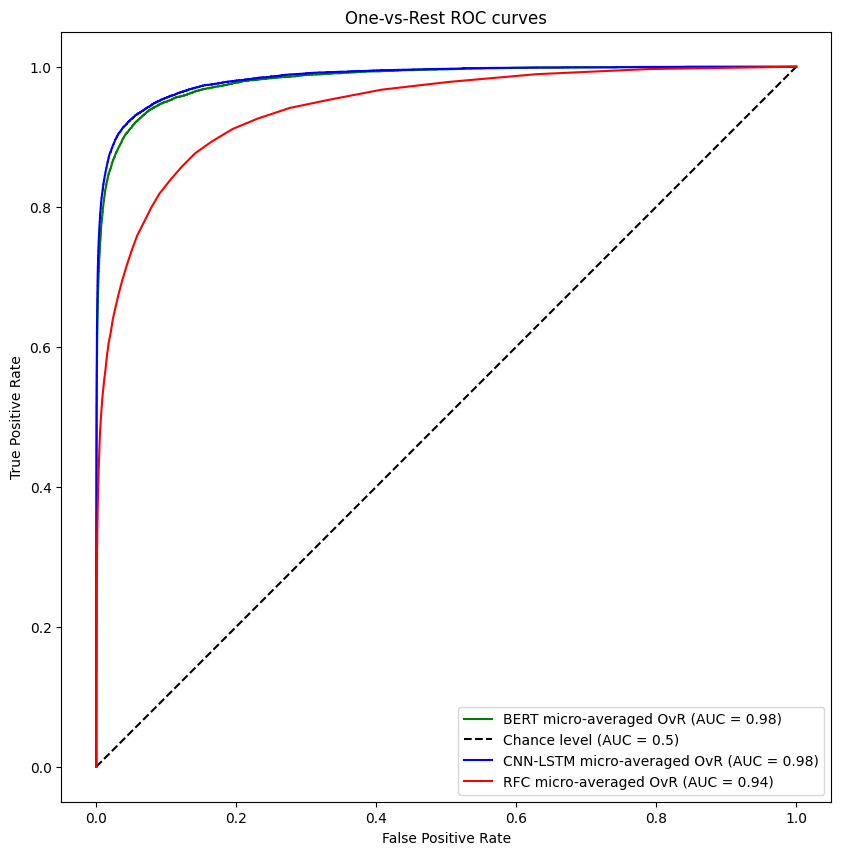

In [20]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

n_classes=15
lb = LabelBinarizer()
lb.fit([i for i in range(n_classes)])
onehot_labels = lb.transform(Y)


fig, ax = plt.subplots(figsize=(10, 10))

roc_display1 =RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    predicted_probas_BERT.ravel(),
    name="BERT micro-averaged OvR",
    color="green",
    plot_chance_level=True,
    ax = ax
)

roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    HNN_long_probas.ravel(),
    name="CNN-LSTM micro-averaged OvR",
    color="blue",
    ax = ax
)
roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    RFC_predict_probas.ravel(),
    name="RFC micro-averaged OvR",
    color="red",
    ax = ax
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()


In [21]:
BERT_long_predictions = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predictions.npy")
Hybrid_NN_long_predictions = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predictions.npy")
RFC_predictions = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/RFC_long_predictions.npy")

In [ ]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix

label_encoder = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/label_encoder.b", "rb"))

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Calculate confusion matrix
cm = confusion_matrix(Y, RFC_predictions)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=3000, vmin=0)
axes[0].set_title('RFC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([i for i in range(15)])
axes[0].set_yticks([i for i in range(15)])
axes[0].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[0].set_yticklabels(label_encoder.classes_, rotation=90)


cm = confusion_matrix(Y, Hybrid_NN_long_predictions)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=3000, vmin=0)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([i for i in range(15)])
axes[1].set_yticks([i for i in range(15)])
axes[1].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[1].set_yticklabels(label_encoder.classes_, rotation=90)

# Calculate confusion matrix
cm = confusion_matrix(Y, BERT_long_predictions)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=3000, vmin=0)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([i for i in range(15)])
axes[2].set_yticks([i for i in range(15)])
axes[2].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[2].set_yticklabels(label_encoder.classes_, rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/tmp/xhorvat9/LTRB

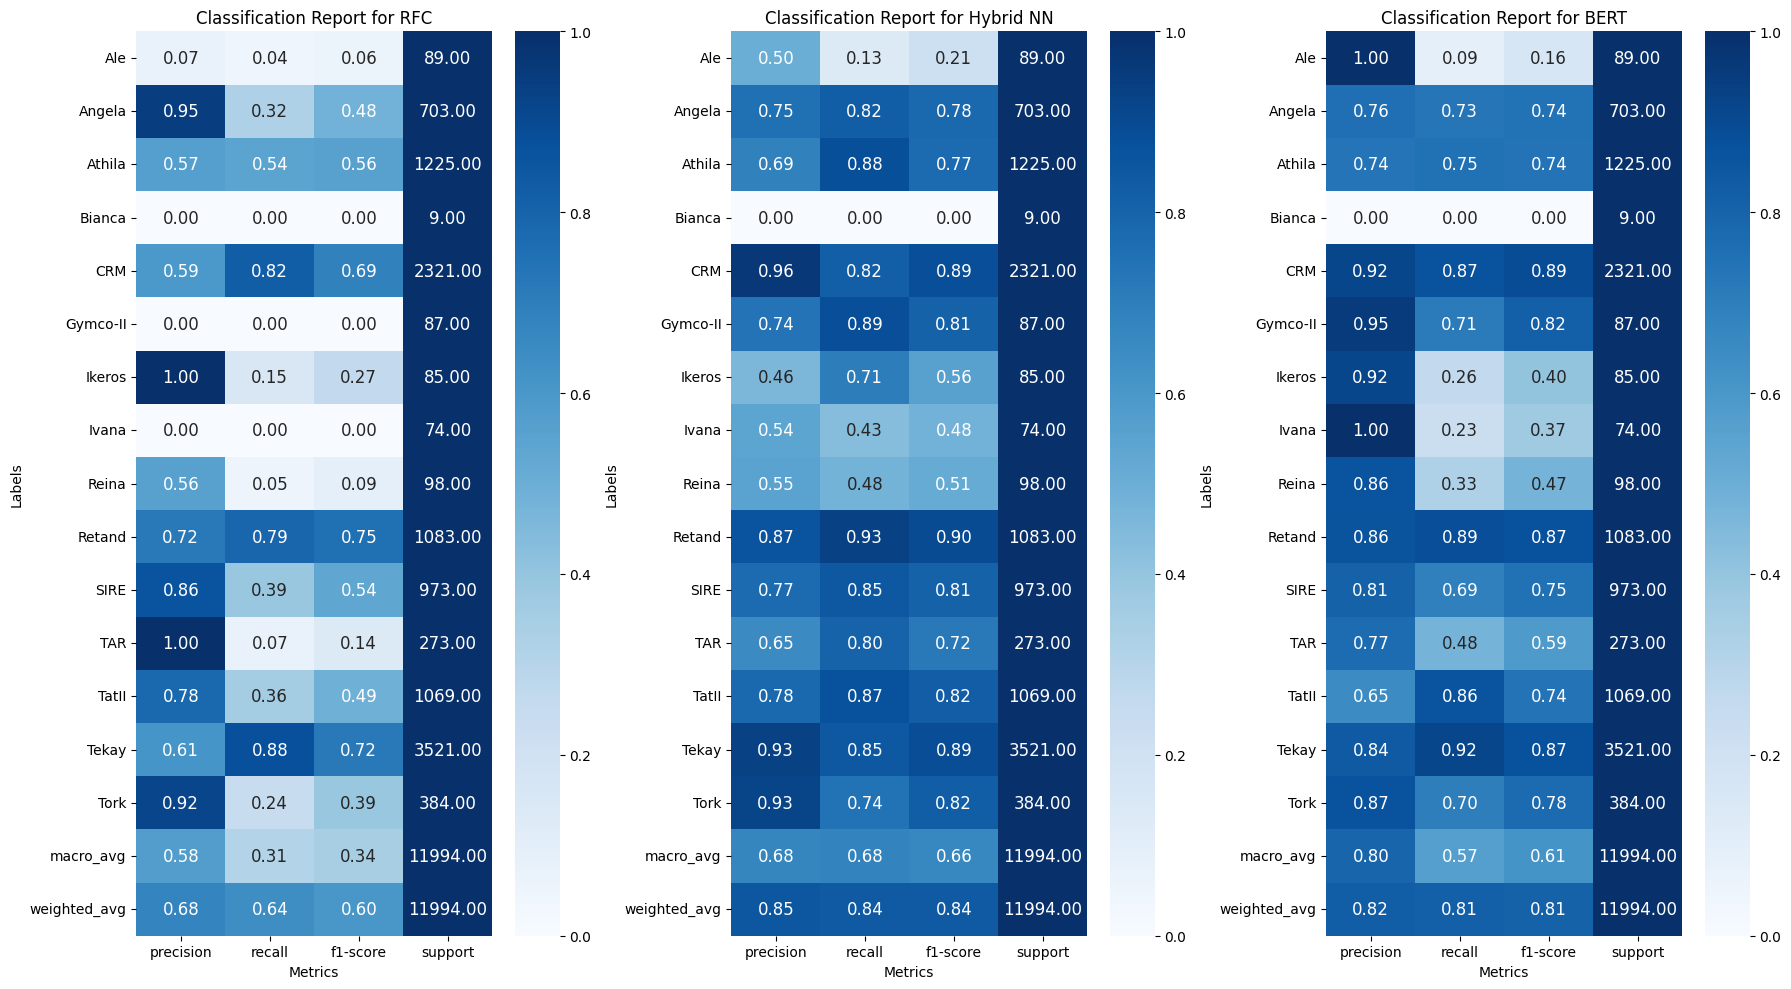

In [30]:
import seaborn as sns
from sklearn.metrics import classification_report

# Create a list of predictions and labels
predictions = [RFC_predictions, Hybrid_NN_long_predictions, BERT_long_predictions]
names = ['RFC', 'Hybrid NN', 'BERT']

# Create a list to store the classification reports
reports = []

# Generate the classification report for each prediction
for pred, name in zip(predictions, names):
    report = classification_report(Y, pred, output_dict=True)
    reports.append(report)

# Plot the classification reports
fig, axes = plt.subplots(1,len(reports), figsize=(6* len(reports), 10))

for i, report in enumerate(reports):
    rep = pd.DataFrame(report).drop("accuracy", axis=1)
    rep.columns = [label_encoder.inverse_transform([i])[0] for i in range(15)] + ["macro_avg", "weighted_avg"]
    rep = rep.T
    rep["support"] = rep["support"].astype(int)
    
    ax = axes[i]
    sns.heatmap(rep, annot=True, cmap="Blues", cbar=True, ax=ax, vmax=1, vmin=0, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title(f"Classification Report for {names[i]}")
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Labels')

plt.tight_layout()
plt.show()

In [64]:
Y_all = np.concatenate((Y_long, Y_short))
np.save("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/Y_all.npy", Y_all)

In [1]:
import numpy as np
predicted_probas_BERT_long = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predict_probas.npy")
HNN_long_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predict_probas.npy")
GBC_predict_probas_long = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_long_predict_probas.npy")

predicted_probas_BERT_short = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_predict_probas.npy")
HNN_short_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/_NN_pred_probas.npy")
GBC_predict_probas_short = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_predict_probas.npy")

In [3]:
# Concatenate the arrays for each model
predicted_probas_BERT = np.concatenate((predicted_probas_BERT_long, predicted_probas_BERT_short))
HNN_probas = np.concatenate((HNN_long_probas, HNN_short_probas))
GBC_predict_probas = np.concatenate((GBC_predict_probas_long, GBC_predict_probas_short))

#Y_all = np.concatenate((Y_long, Y_short))
Y_all = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/Y_all.npy")

Y_all.shape[0] == predicted_probas_BERT.shape[0] == HNN_probas.shape[0] == GBC_predict_probas.shape[0]

True

## All sequences Results


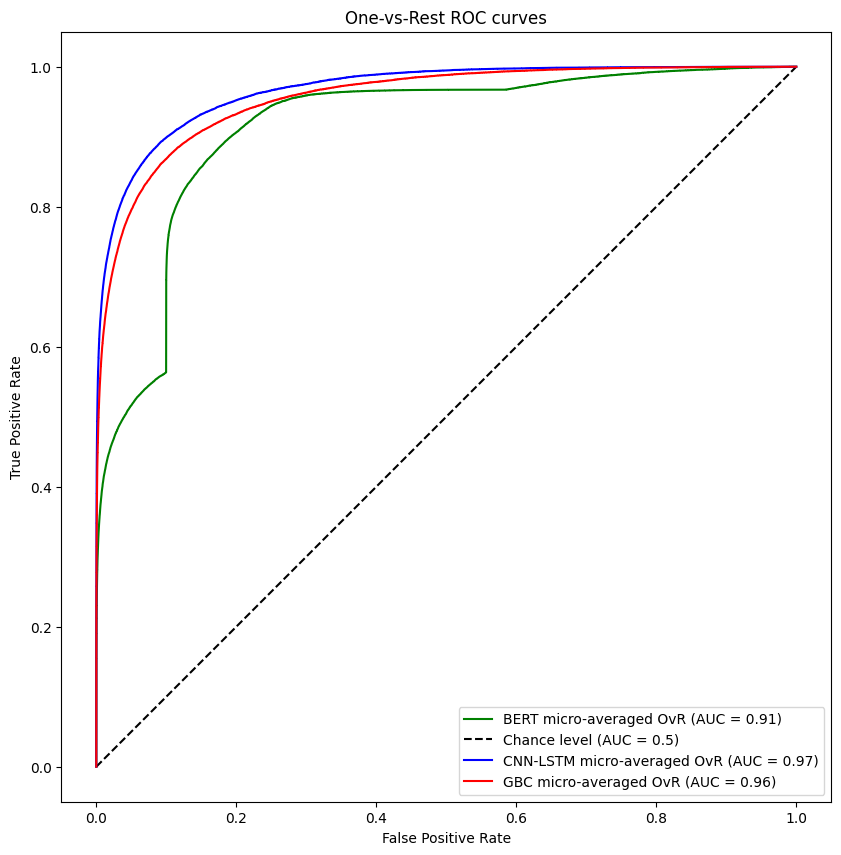

In [74]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

n_classes=15
lb = LabelBinarizer()
lb.fit([i for i in range(n_classes)])
onehot_labels = lb.transform(Y_all)


fig, ax = plt.subplots(figsize=(10, 10))

roc_display1 =RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    predicted_probas_BERT.ravel(),
    name="BERT micro-averaged OvR",
    color="green",
    plot_chance_level=True,
    ax = ax
)

roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    HNN_probas.ravel(),
    name="CNN-LSTM micro-averaged OvR",
    color="blue",
    ax = ax
)
roc_display2 = RocCurveDisplay.from_predictions(
    onehot_labels.ravel(),
    RFC_predict_probas.ravel(),
    name="GBC micro-averaged OvR",
    color="red",
    ax = ax
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()


In [4]:
predicted_labels_BERT = np.argmax(predicted_probas_BERT, axis=1)
predicted_labels_HNN = np.argmax(HNN_probas, axis=1)
predicted_labels_GBC = np.argmax(GBC_predict_probas, axis=1)


/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


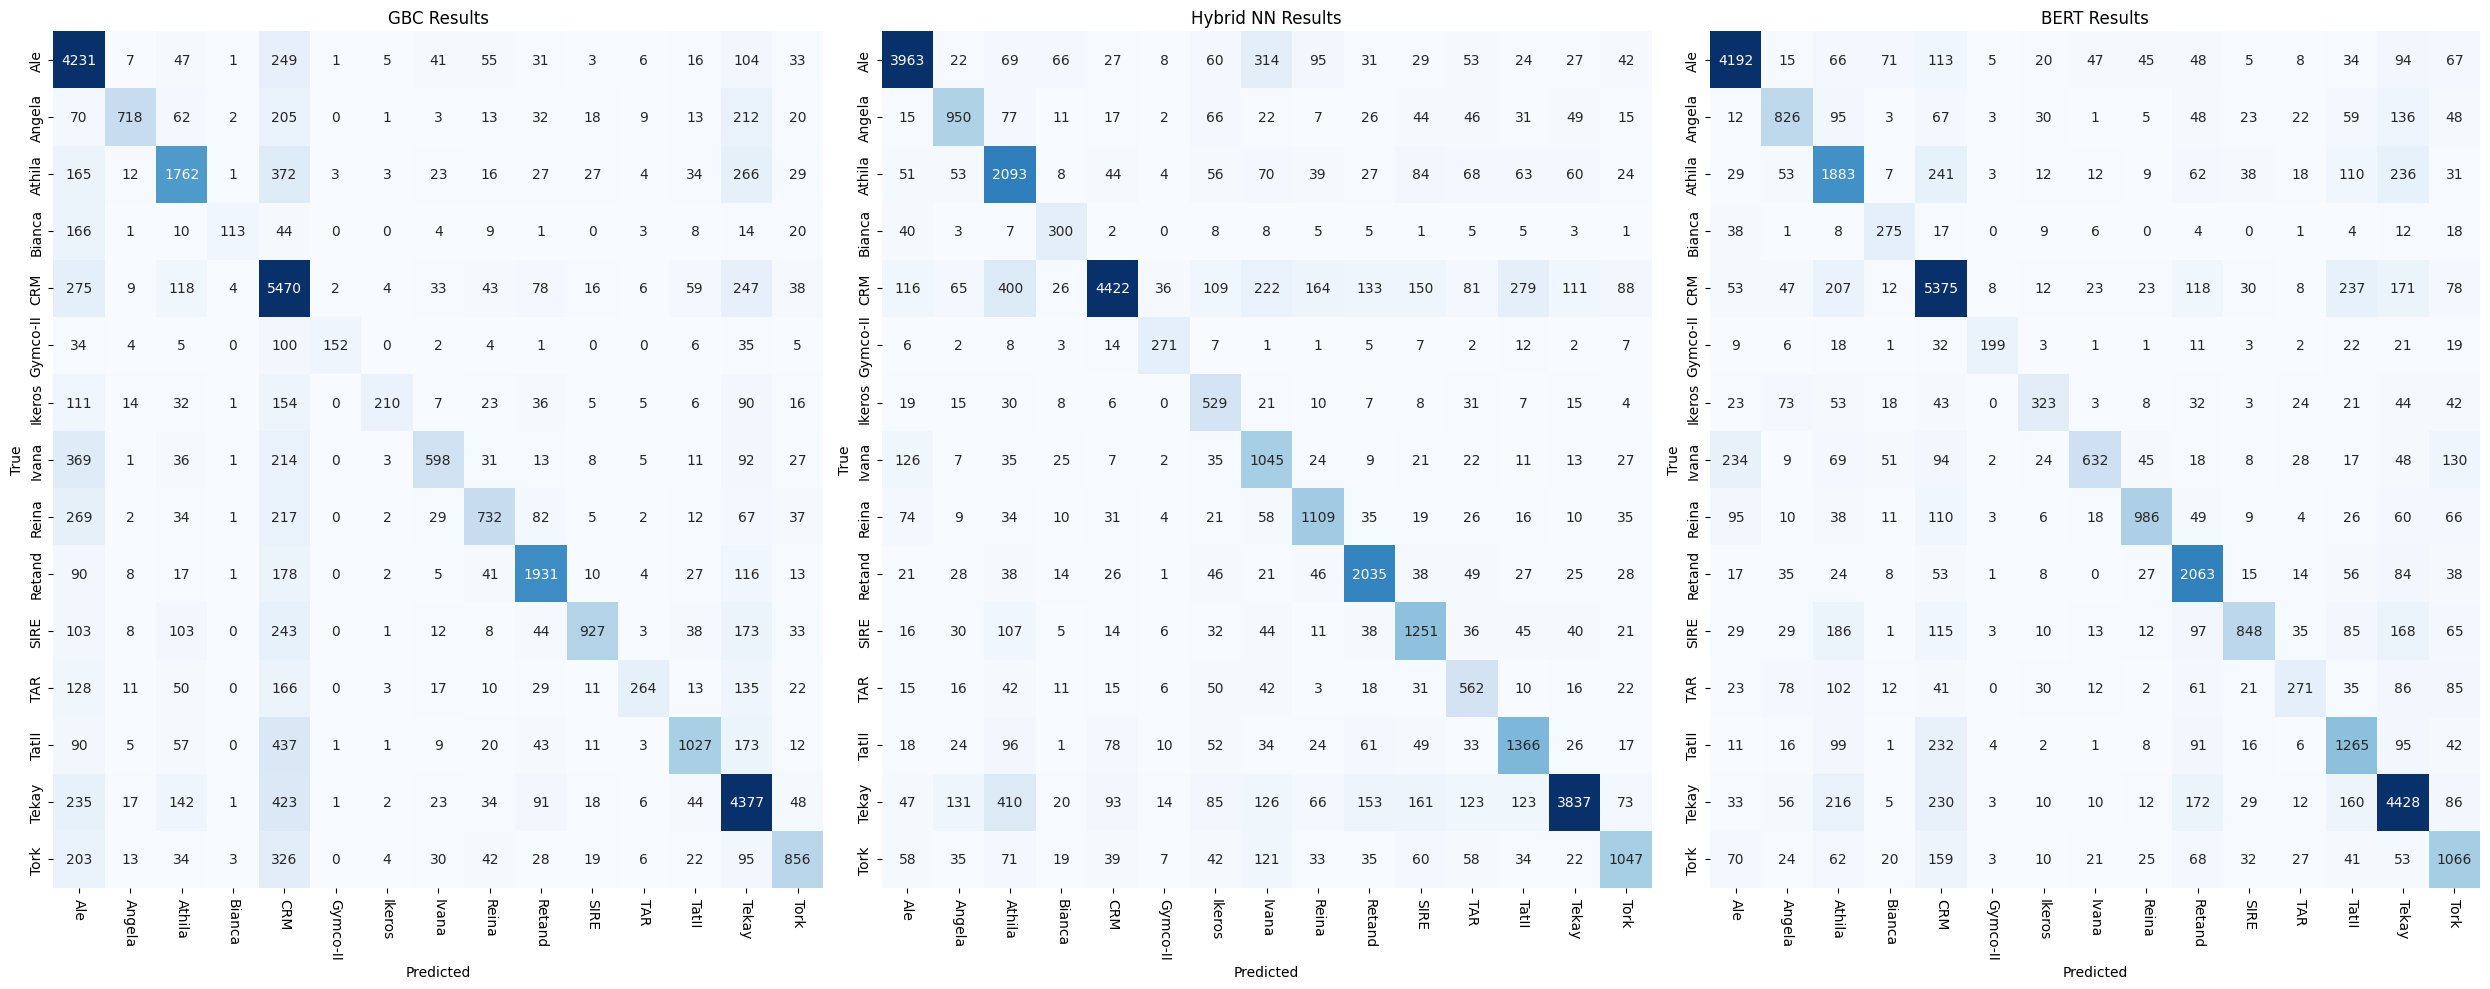

In [8]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_encoder = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/label_encoder.b", "rb"))

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Calculate confusion matrix
cm = confusion_matrix(Y_all, predicted_labels_GBC)
# Plot GBC results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=3000, vmin=0)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[0].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[0].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[0].set_yticklabels(label_encoder.classes_, rotation=90)


cm = confusion_matrix(Y_all, predicted_labels_HNN)
# Plot Hybrid NN results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=3000, vmin=0)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[1].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[1].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[1].set_yticklabels(label_encoder.classes_, rotation=90)

# Calculate confusion matrix
cm = confusion_matrix(Y_all, predicted_labels_BERT)
# Plot BERT results
g = sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=3000, vmin=0)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[2].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[2].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[2].set_yticklabels(label_encoder.classes_, rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

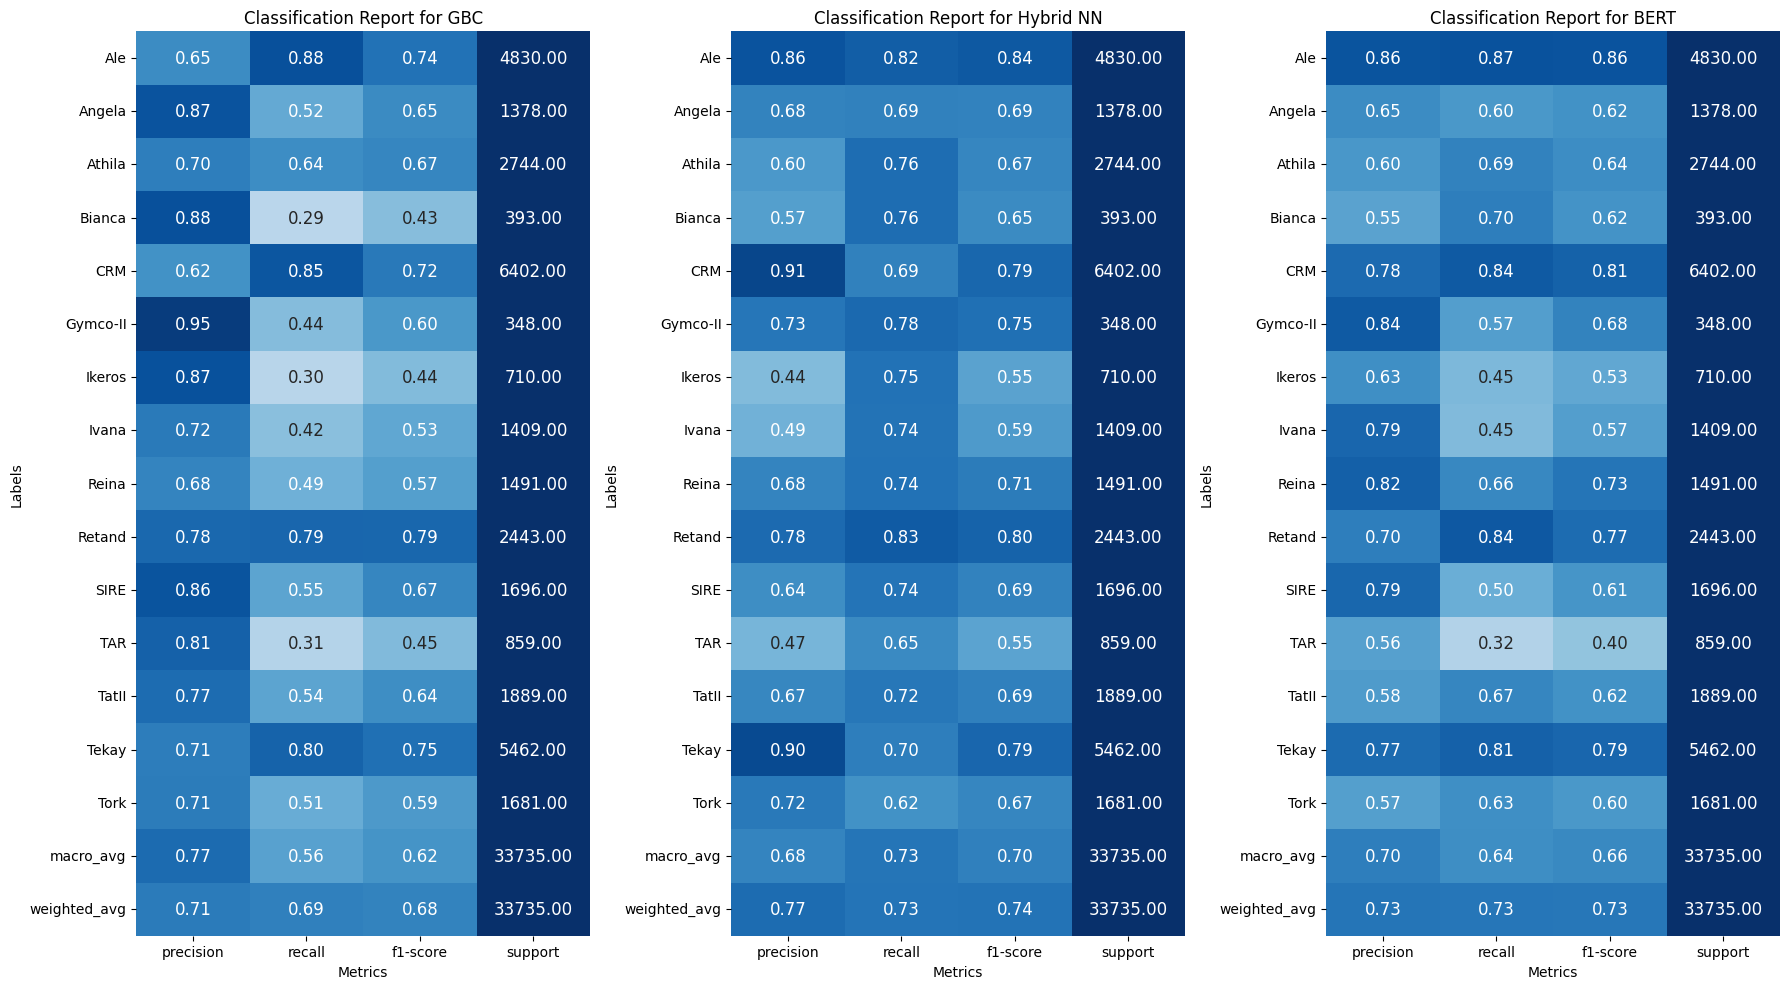

In [86]:
import seaborn as sns
from sklearn.metrics import classification_report

# Create a list of predictions and labels
predictions = [predicted_labels_GBC, predicted_labels_HNN, predicted_labels_BERT]
names = ['GBC', 'Hybrid NN', 'BERT']

# Create a list to store the classification reports
reports = []

# Generate the classification report for each prediction
for pred, name in zip(predictions, names):
    report = classification_report(Y_all, pred, output_dict=True)
    reports.append(report)

# Plot the classification reports
fig, axes = plt.subplots(1,len(reports), figsize=(6* len(reports), 10))

for i, report in enumerate(reports):
    rep = pd.DataFrame(report).drop("accuracy", axis=1)
    rep.columns = [label_encoder.inverse_transform([i])[0] for i in range(15)] + ["macro_avg", "weighted_avg"]
    rep = rep.T
    rep["support"] = rep["support"].astype(int)
    
    ax = axes[i]
    sns.heatmap(rep, annot=True, cmap="Blues", cbar=False, ax=ax, vmax=1, vmin=0, annot_kws={"size": 12}, fmt=".2f")
    ax.set_title(f"Classification Report for {names[i]}")
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Labels')

plt.tight_layout()
plt.show()

## You can pass the precomputed distance matrix as linkage to clustermap():


In [10]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

In [12]:
DF_corr = DF.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

In [ ]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')
sns.clustermap(DF_dism, row_linkage=linkage, col_linkage=linkage)

In [72]:
from Bio import Phylo
p = Phylo.read("tree_struck.newick", "newick")

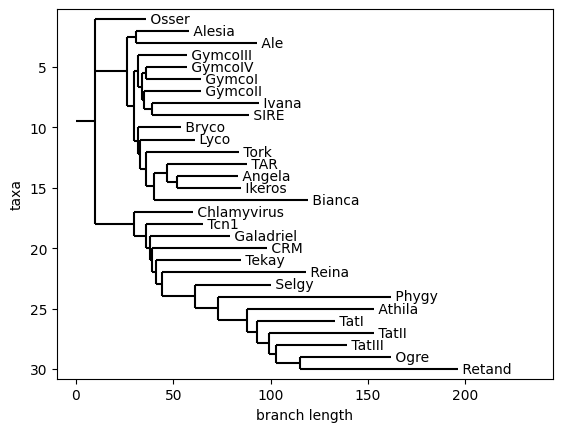

In [73]:
Phylo.draw(p)

In [74]:
all_lineages = list(data.keys())
list_to_remove = []
for lineage in all_lineages:
    if lineage not in list(le.classes_):
        p.prune(lineage)

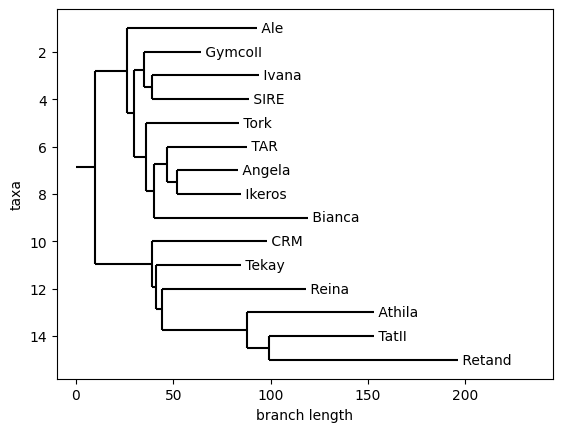

In [75]:
Phylo.draw(p)

In [77]:
p.distance("Tekay", "Ikeros")

150.0

In [86]:
classes.shape[0]

(15,)

In [92]:
classes = le.classes_
classes[5] = "GymcoII"
distances = np.zeros((classes.shape[0], classes.shape[0]))
for  i, c1 in enumerate(classes):
    for j, c2 in enumerate(classes):
        distances[i, j] = p.distance(c1, c2)
        #print(c1, c2, p.distance(c1, c2))

In [95]:
d = pd.DataFrame(distances)
d.columns = classes
d.index = classes

In [100]:
d

,Ale,Angela,Athila,Bianca,CRM,GymcoII,Ikeros,Ivana,Reina,Retand,SIRE,TAR,TatII,Tekay,Tork
Ale,0.0,124.0,226.0,160.0,171.0,105.0,126.0,135.0,191.0,269.0,130.0,129.0,226.0,158.0,125.0
Angela,124.0,0.0,216.0,122.0,161.0,87.0,64.0,117.0,181.0,259.0,112.0,77.0,216.0,148.0,95.0
Athila,226.0,216.0,0.0,252.0,173.0,197.0,218.0,227.0,183.0,173.0,222.0,221.0,130.0,156.0,217.0
Bianca,160.0,122.0,252.0,0.0,197.0,123.0,124.0,153.0,217.0,295.0,148.0,127.0,252.0,184.0,131.0
CRM,171.0,161.0,173.0,197.0,0.0,142.0,163.0,172.0,138.0,216.0,167.0,166.0,173.0,105.0,162.0
GymcoII,105.0,87.0,197.0,123.0,142.0,0.0,89.0,88.0,162.0,240.0,83.0,92.0,197.0,129.0,88.0
Ikeros,126.0,64.0,218.0,124.0,163.0,89.0,0.0,119.0,183.0,261.0,114.0,79.0,218.0,150.0,97.0
Ivana,135.0,117.0,227.0,153.0,172.0,88.0,119.0,0.0,192.0,270.0,105.0,122.0,227.0,159.0,118.0
Reina,191.0,181.0,183.0,217.0,138.0,162.0,183.0,192.0,0.0,226.0,187.0,186.0,183.0,121.0,182.0
Retand,269.0,259.0,173.0,295.0,216.0,240.0,261.0,270.0,226.0,0.0,265.0,264.0,151.0,199.0,260.0


In [54]:
networkx.adjacency_matrix(n).todense().shape

(58, 58)

In [31]:
n = Phylo.to_networkx(p)

In [60]:
df = networkx.to_pandas_adjacency(n)


In [1]:
import pandas as pd

data = {
    'Alesia': [0.0, 89.0, 63.0, 70.0, 100.0, 95.0, 70.0, 63.0, 89.0, 91.0, 94.0, 125.0, 90.0, 67.0, 60.0, 200.0, 234.0, 177.0, 191.0, 171.0, 191.0, 200.0, 138.0, 156.0, 123.0, 136.0, 117.0, 103.0, 98.0, 74.0],
    'Ale': [89.0, 0.0, 98.0, 105.0, 135.0, 130.0, 105.0, 98.0, 124.0, 126.0, 129.0, 160.0, 125.0, 102.0, 95.0, 235.0, 269.0, 212.0, 226.0, 206.0, 226.0, 235.0, 173.0, 191.0, 158.0, 171.0, 152.0, 138.0, 133.0, 109.0],
    'GymcoIV': [63.0, 98.0, 0.0, 49.0, 83.0, 78.0, 53.0, 50.0, 80.0, 82.0, 85.0, 116.0, 81.0, 58.0, 51.0, 199.0, 233.0, 176.0, 190.0, 170.0, 190.0, 199.0, 137.0, 155.0, 122.0, 135.0, 116.0, 102.0, 97.0, 73.0],
    'GymcoI': [70.0, 105.0, 49.0, 0.0, 90.0, 85.0, 60.0, 57.0, 87.0, 89.0, 92.0, 123.0, 88.0, 65.0, 58.0, 206.0, 240.0, 183.0, 197.0, 177.0, 197.0, 206.0, 144.0, 162.0, 129.0, 142.0, 123.0, 109.0, 104.0, 80.0],
    'Ivana': [100.0, 135.0, 83.0, 90.0, 0.0, 105.0, 88.0, 87.0, 117.0, 119.0, 122.0, 153.0, 118.0, 95.0, 88.0, 236.0, 270.0, 213.0, 227.0, 207.0, 227.0, 236.0, 174.0, 192.0, 159.0, 172.0, 153.0, 139.0, 134.0, 110.0],
    'SIRE': [95.0, 130.0, 78.0, 85.0, 105.0, 0.0, 83.0, 82.0, 112.0, 114.0, 117.0, 148.0, 113.0, 90.0, 83.0, 231.0, 265.0, 208.0, 222.0, 202.0, 222.0, 231.0, 169.0, 187.0, 154.0, 167.0, 148.0, 134.0, 129.0, 105.0],
    'Gymco-II': [70.0, 105.0, 53.0, 60.0, 88.0, 83.0, 0.0, 57.0, 87.0, 89.0, 92.0, 123.0, 88.0, 65.0, 58.0, 206.0, 240.0, 183.0, 197.0, 177.0, 197.0, 206.0, 144.0, 162.0, 129.0, 142.0, 123.0, 109.0, 104.0, 80.0],
    'GymcoIII': [63.0, 98.0, 50.0, 57.0, 87.0, 82.0, 57.0, 0.0, 80.0, 82.0, 85.0, 116.0, 81.0, 58.0, 51.0, 199.0, 233.0, 176.0, 190.0, 170.0, 190.0, 199.0, 137.0, 155.0, 122.0, 135.0, 116.0, 102.0, 97.0, 73.0],
    'Angela': [89.0, 124.0, 80.0, 87.0, 117.0, 112.0, 87.0, 80.0, 0.0, 64.0, 77.0, 122.0, 95.0, 78.0, 73.0, 225.0, 259.0, 202.0, 216.0, 196.0, 216.0, 225.0, 163.0, 181.0, 148.0, 161.0, 142.0, 128.0, 123.0, 99.0],
    'Ikeros': [91.0, 126.0, 82.0, 89.0, 119.0, 114.0, 89.0, 82.0, 64.0, 0.0, 79.0, 124.0, 97.0, 80.0, 75.0, 227.0, 261.0, 204.0, 218.0, 198.0, 218.0, 227.0, 165.0, 183.0, 150.0, 163.0, 144.0, 130.0, 125.0, 101.0],
    'TAR': [94.0, 129.0, 85.0, 92.0, 122.0, 117.0, 92.0, 85.0, 77.0, 79.0, 0.0, 127.0, 100.0, 83.0, 78.0, 230.0, 264.0, 207.0, 221.0, 201.0, 221.0, 230.0, 168.0, 186.0, 153.0, 166.0, 147.0, 133.0, 128.0, 104.0],
    'Bianca': [125.0, 160.0, 116.0, 123.0, 153.0, 148.0, 123.0, 116.0, 122.0, 124.0, 127.0, 0.0, 131.0, 114.0, 109.0, 261.0, 295.0, 238.0, 252.0, 232.0, 252.0, 261.0, 199.0, 217.0, 184.0, 197.0, 178.0, 164.0, 159.0, 135.0],
    'Tork': [90.0, 125.0, 81.0, 88.0, 118.0, 113.0, 88.0, 81.0, 95.0, 97.0, 100.0, 131.0, 0.0, 79.0, 74.0, 226.0, 260.0, 203.0, 217.0, 197.0, 217.0, 226.0, 164.0, 182.0, 149.0, 162.0, 143.0, 129.0, 124.0, 100.0],
    'Lyco': [67.0, 102.0, 58.0, 65.0, 95.0, 90.0, 65.0, 58.0, 78.0, 80.0, 83.0, 114.0, 79.0, 0.0, 51.0, 203.0, 237.0, 180.0, 194.0, 174.0, 194.0, 203.0, 141.0, 159.0, 126.0, 139.0, 120.0, 106.0, 101.0, 77.0],
    'Bryco': [60.0, 95.0, 51.0, 58.0, 88.0, 83.0, 58.0, 51.0, 73.0, 75.0, 78.0, 109.0, 74.0, 51.0, 0.0, 196.0, 230.0, 173.0, 187.0, 167.0, 187.0, 196.0, 134.0, 152.0, 119.0, 132.0, 113.0, 99.0, 94.0, 70.0],
    'Ogre': [200.0, 235.0, 199.0, 206.0, 236.0, 231.0, 206.0, 199.0, 225.0, 227.0, 230.0, 261.0, 226.0, 203.0, 196.0, 0.0, 128.0, 95.0, 117.0, 109.0, 139.0, 178.0, 140.0, 192.0, 165.0, 182.0, 165.0, 155.0, 162.0, 178.0],
    'Retand': [234.0, 269.0, 233.0, 240.0, 270.0, 265.0, 240.0, 233.0, 259.0, 261.0, 264.0, 295.0, 260.0, 237.0, 230.0, 128.0, 0.0, 129.0, 151.0, 143.0, 173.0, 212.0, 174.0, 226.0, 199.0, 216.0, 199.0, 189.0, 196.0, 212.0],
    'TatIII': [177.0, 212.0, 176.0, 183.0, 213.0, 208.0, 183.0, 176.0, 202.0, 204.0, 207.0, 238.0, 203.0, 180.0, 173.0, 95.0, 129.0, 0.0, 94.0, 86.0, 116.0, 155.0, 117.0, 169.0, 142.0, 159.0, 142.0, 132.0, 139.0, 155.0],
    'TatII': [191.0, 226.0, 190.0, 197.0, 227.0, 222.0, 197.0, 190.0, 216.0, 218.0, 221.0, 252.0, 217.0, 194.0, 187.0, 117.0, 151.0, 94.0, 0.0, 100.0, 130.0, 169.0, 131.0, 183.0, 156.0, 173.0, 156.0, 146.0, 153.0, 169.0],
    "TatI": [171.0, 206.0, 170.0, 177.0, 207.0, 202.0, 177.0, 170.0, 196.0, 198.0, 201.0, 232.0, 197.0, 174.0, 167.0, 109.0, 143.0, 86.0, 100.0, 0.0, 110.0, 149.0, 111.0, 163.0, 136.0, 153.0, 136.0, 126.0, 133.0, 149.0],
    "Athila": [191.0, 226.0, 190.0, 197.0, 227.0, 222.0, 197.0, 190.0, 216.0, 218.0, 221.0, 252.0, 217.0, 194.0, 187.0, 139.0, 173.0, 116.0, 130.0, 110.0, 0.0, 169.0, 131.0, 183.0, 156.0, 173.0, 156.0, 146.0, 153.0, 169.0],
    "Phygy": [200.0, 235.0, 199.0, 206.0, 236.0, 231.0, 206.0, 199.0, 225.0, 227.0, 230.0, 261.0, 226.0, 203.0, 196.0, 178.0, 212.0, 155.0, 169.0, 149.0, 169.0, 0.0, 140.0, 192.0, 165.0, 182.0, 165.0, 155.0, 162.0, 178.0],
    "Selgy": [138.0, 173.0, 137.0, 144.0, 174.0, 169.0, 144.0, 137.0, 163.0, 165.0, 168.0, 199.0, 164.0, 141.0, 134.0, 140.0, 174.0, 117.0, 131.0, 111.0, 131.0, 140.0, 0.0, 130.0, 103.0, 120.0, 103.0, 93.0, 100.0, 116.0],
    "Reina": [156.0, 191.0, 155.0, 162.0, 192.0, 187.0, 162.0, 155.0, 181.0, 183.0, 186.0, 217.0, 182.0, 159.0, 152.0, 192.0, 226.0, 169.0, 183.0, 163.0, 183.0, 192.0, 130.0, 0.0, 121.0, 138.0, 121.0, 111.0, 118.0, 134.0],
    "Tekay": [123.0, 158.0, 122.0, 129.0, 159.0, 154.0, 129.0, 122.0, 148.0, 150.0, 153.0, 184.0, 149.0, 126.0, 119.0, 165.0, 199.0, 142.0, 156.0, 136.0, 156.0, 165.0, 103.0, 121.0, 0.0, 105.0, 88.0, 78.0, 85.0, 101.0],
    "CRM": [136.0, 171.0, 135.0, 142.0, 172.0, 167.0, 142.0, 135.0, 161.0, 163.0, 166.0, 197.0, 162.0, 139.0, 132.0, 182.0, 216.0, 159.0, 173.0, 153.0, 173.0, 182.0, 120.0, 138.0, 105.0, 0.0, 101.0, 91.0, 98.0, 114.0],
    "Galadriel": [117.0, 152.0, 116.0, 123.0, 153.0, 148.0, 123.0, 116.0, 142.0, 144.0, 147.0, 178.0, 143.0, 120.0, 113.0, 165.0, 199.0, 142.0, 156.0, 136.0, 156.0, 165.0, 103.0, 121.0, 88.0, 101.0, 0.0, 72.0, 79.0, 95.0],
    "Tcn1": [103.0, 138.0, 102.0, 109.0, 139.0, 134.0, 109.0, 102.0, 128.0, 130.0, 133.0, 164.0, 129.0, 106.0, 99.0, 155.0, 189.0, 132.0, 146.0, 126.0, 146.0, 155.0, 93.0, 111.0, 78.0, 91.0, 72.0, 0.0, 65.0, 81.0],
    "Chlamyvirus": [98.0, 133.0, 97.0, 104.0, 134.0, 129.0, 104.0, 97.0, 123.0, 125.0, 128.0, 159.0, 124.0, 101.0, 94.0, 162.0, 196.0, 139.0, 153.0, 133.0, 153.0, 162.0, 100.0, 118.0, 85.0, 98.0, 79.0, 65.0, 0.0, 76.0],
    "Osser": [74.0, 109.0, 73.0, 80.0, 110.0, 105.0, 80.0, 73.0, 99.0, 101.0, 104.0, 135.0, 100.0, 77.0, 70.0, 178.0, 212.0, 155.0, 169.0, 149.0, 169.0, 178.0, 116.0, 134.0, 101.0, 114.0, 95.0, 81.0, 76.0, 0.0]
}

# Create DataFrame
df = pd.DataFrame(data, index=data.keys())
df.columns = data.keys()


In [4]:
from sklearn.preprocessing import LabelEncoder
import pickle

le = pickle.load(open("label_encoder.b", "rb"))
df_filtered = df.loc[le.classes_, le.classes_]
df_filtered = df_filtered.reindex(sorted(df_filtered.columns), axis=1)
df_filtered = df_filtered.reindex(sorted(df_filtered.index))


/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [26]:
import numpy as np

# Assuming df_filtered is a pandas DataFrame
# Convert it to a numpy array
df_filtered_array = (300-df_filtered).to_numpy()

# Set the diagonal elements to 0
np.fill_diagonal(df_filtered_array, 0)

# Convert the modified array back to a DataFrame
df_filtered_modified = pd.DataFrame(df_filtered_array, columns=df_filtered.columns, index=df_filtered.index)


In [27]:
df_filtered_modified

,Ale,Angela,Athila,Bianca,CRM,Gymco-II,Ikeros,Ivana,Reina,Retand,SIRE,TAR,TatII,Tekay,Tork
Ale,0.0,176.0,74.0,140.0,129.0,195.0,174.0,165.0,109.0,31.0,170.0,171.0,74.0,142.0,175.0
Angela,176.0,0.0,84.0,178.0,139.0,213.0,236.0,183.0,119.0,41.0,188.0,223.0,84.0,152.0,205.0
Athila,74.0,84.0,0.0,48.0,127.0,103.0,82.0,73.0,117.0,127.0,78.0,79.0,170.0,144.0,83.0
Bianca,140.0,178.0,48.0,0.0,103.0,177.0,176.0,147.0,83.0,5.0,152.0,173.0,48.0,116.0,169.0
CRM,129.0,139.0,127.0,103.0,0.0,158.0,137.0,128.0,162.0,84.0,133.0,134.0,127.0,195.0,138.0
Gymco-II,195.0,213.0,103.0,177.0,158.0,0.0,211.0,212.0,138.0,60.0,217.0,208.0,103.0,171.0,212.0
Ikeros,174.0,236.0,82.0,176.0,137.0,211.0,0.0,181.0,117.0,39.0,186.0,221.0,82.0,150.0,203.0
Ivana,165.0,183.0,73.0,147.0,128.0,212.0,181.0,0.0,108.0,30.0,195.0,178.0,73.0,141.0,182.0
Reina,109.0,119.0,117.0,83.0,162.0,138.0,117.0,108.0,0.0,74.0,113.0,114.0,117.0,179.0,118.0
Retand,31.0,41.0,127.0,5.0,84.0,60.0,39.0,30.0,74.0,0.0,35.0,36.0,149.0,101.0,40.0


In [101]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(d), method='average')

In [111]:
linkage

array([[  1.        ,   6.        ,  64.        ,   2.        ],
       [ 11.        ,  15.        ,  78.        ,   3.        ],
       [  5.        ,  10.        ,  83.        ,   2.        ],
       [  7.        ,  17.        ,  96.5       ,   3.        ],
       [ 14.        ,  16.        ,  97.33333333,   4.        ],
       [  4.        ,  13.        , 105.        ,   2.        ],
       [ 18.        ,  19.        , 107.33333333,   7.        ],
       [  0.        ,  21.        , 124.85714286,   8.        ],
       [  8.        ,  20.        , 129.5       ,   3.        ],
       [  2.        ,  12.        , 130.        ,   2.        ],
       [  3.        ,  22.        , 136.        ,   9.        ],
       [  9.        ,  24.        , 162.        ,   3.        ],
       [ 23.        ,  25.        , 169.11111111,  12.        ],
       [ 26.        ,  27.        , 223.33333333,  15.        ]])

In [7]:
import numpy as np
predicted_probas_BERT_long = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_long_predict_probas.npy")
HNN_long_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/HNN_long_predict_probas.npy")
GBC_predict_probas_long = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_long_predict_probas.npy")

predicted_probas_BERT_short = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT_predict_probas.npy")
HNN_short_probas = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/_NN_pred_probas.npy")
GBC_predict_probas_short = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/GBC_predict_probas.npy")

In [8]:
# Concatenate the arrays for each model
predicted_probas_BERT = np.concatenate((predicted_probas_BERT_long, predicted_probas_BERT_short))
HNN_probas = np.concatenate((HNN_long_probas, HNN_short_probas))
GBC_predict_probas = np.concatenate((GBC_predict_probas_long, GBC_predict_probas_short))

#Y_all = np.concatenate((Y_long, Y_short))
Y_all = np.load("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/Y_all.npy")

Y_all.shape[0] == predicted_probas_BERT.shape[0] == HNN_probas.shape[0] == GBC_predict_probas.shape[0]

True

In [11]:
predicted_labels_BERT = np.argmax(predicted_probas_BERT, axis=1)
predicted_labels_HNN = np.argmax(HNN_probas, axis=1)
predicted_labels_GBC = np.argmax(GBC_predict_probas, axis=1)


In [ ]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_encoder = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/label_encoder.b", "rb"))

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Calculate confusion matrix
cm = confusion_matrix(Y_all, predicted_labels_GBC)
# Plot GBC results
g = sns.clustermap(cm, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[0], vmax=3000, vmin=0)
axes[0].set_title('GBC Results')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[0].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[0].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[0].set_yticklabels(label_encoder.classes_, rotation=90)


cm = confusion_matrix(Y_all, predicted_labels_HNN)
# Plot Hybrid NN results
g = sns.clustermap(cm, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[1], vmax=3000, vmin=0)
axes[1].set_title('Hybrid NN Results')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[1].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[1].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[1].set_yticklabels(label_encoder.classes_, rotation=90)

# Calculate confusion matrix
cm = confusion_matrix(Y_all, predicted_labels_BERT)
# Plot BERT results
g = sns.clustermap(cm, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt="d", cbar=False, ax=axes[2], vmax=3000, vmin=0)
axes[2].set_title('BERT Results')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[2].set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
axes[2].set_xticklabels(label_encoder.classes_, rotation=-90)
axes[2].set_yticklabels(label_encoder.classes_, rotation=90)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [106]:
l = le.inverse_transform([9, 2, 12, 8, 4, 13, 3, 0, 7, 5, 10, 14, 11, 1, 6])

In [119]:
linkage[:,2] = linkage[:,2]*-1

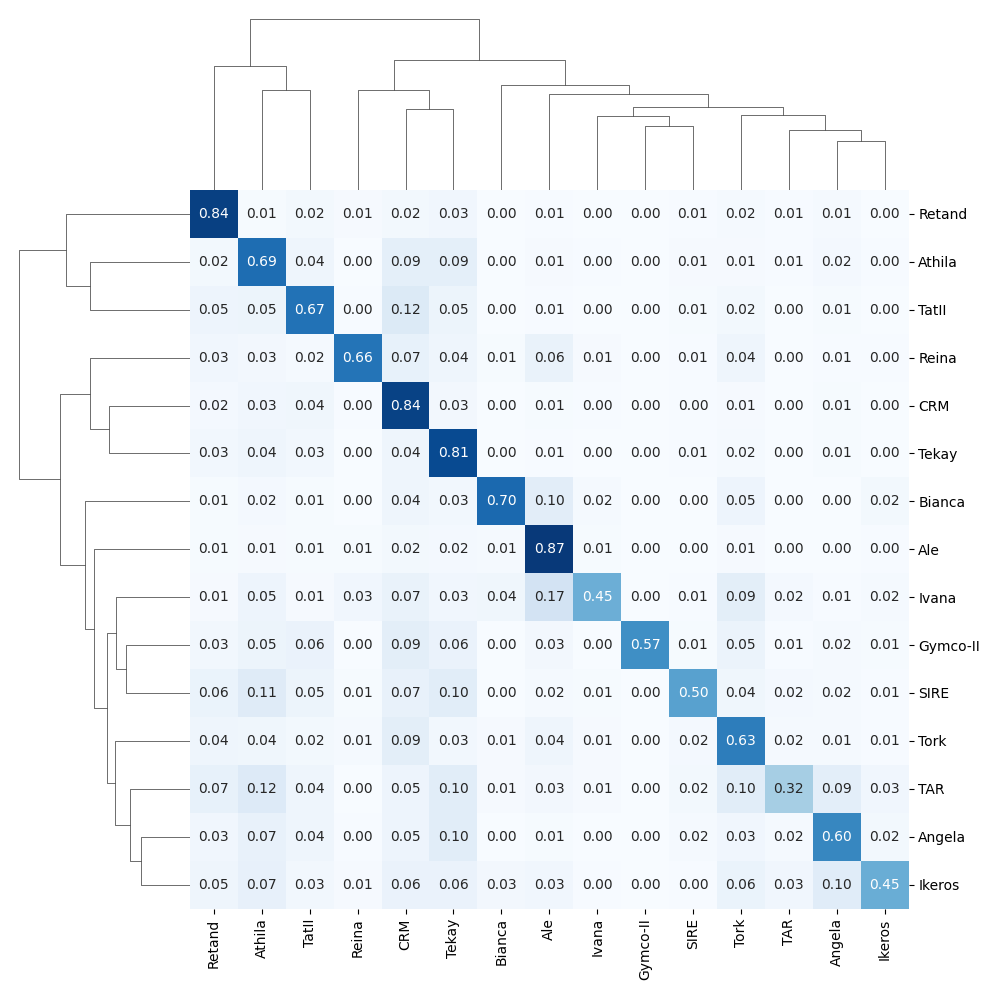

In [122]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_all, predicted_labels_BERT)
dt = pd.DataFrame(cm)
dt.columns = label_encoder.classes_
dt.index = label_encoder.classes_
dt_normalized = dt.div(dt.sum(axis=1), axis=0)

g = sns.clustermap(dt_normalized, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt=".2f", cbar=False, vmax=0.9, vmin=0)
#g.set_title('BERT Results')
#g.set_xlabel('Predicted')
#g.set_ylabel('True')
#g.set_xticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
#g.set_yticks([i + 0.5 for i in range(15)])  # Move ticks to center of cell
#g.set_xticklabels(label_encoder.classes_, rotation=-90)
#g.set_yticklabels(label_encoder.classes_, rotation=90)
#plt.xticks()
g.cax.set_visible(False)
#g.fig.suptitle('BERT Predictions') 
# Save the plot as SVG
plt.savefig('BERT_lineage.svg', format='svg')

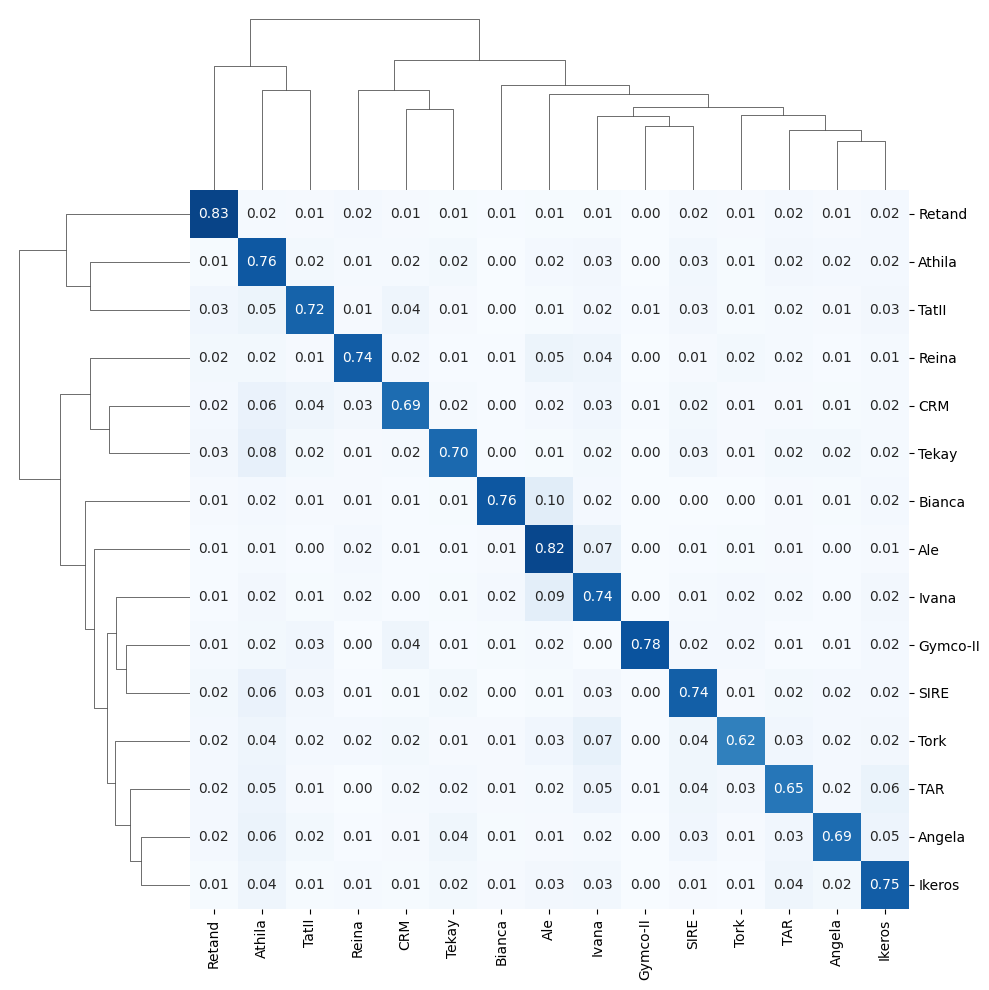

In [121]:
cm = confusion_matrix(Y_all, predicted_labels_HNN)
dt = pd.DataFrame(cm)
dt.columns = label_encoder.classes_
dt.index = label_encoder.classes_
dt_normalized = dt.div(dt.sum(axis=1), axis=0)

g = sns.clustermap(dt_normalized, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt=".2f", cbar=False, vmax=0.9, vmin=0)
g.cax.set_visible(False)
plt.savefig('NN_lineage.svg', format='svg')

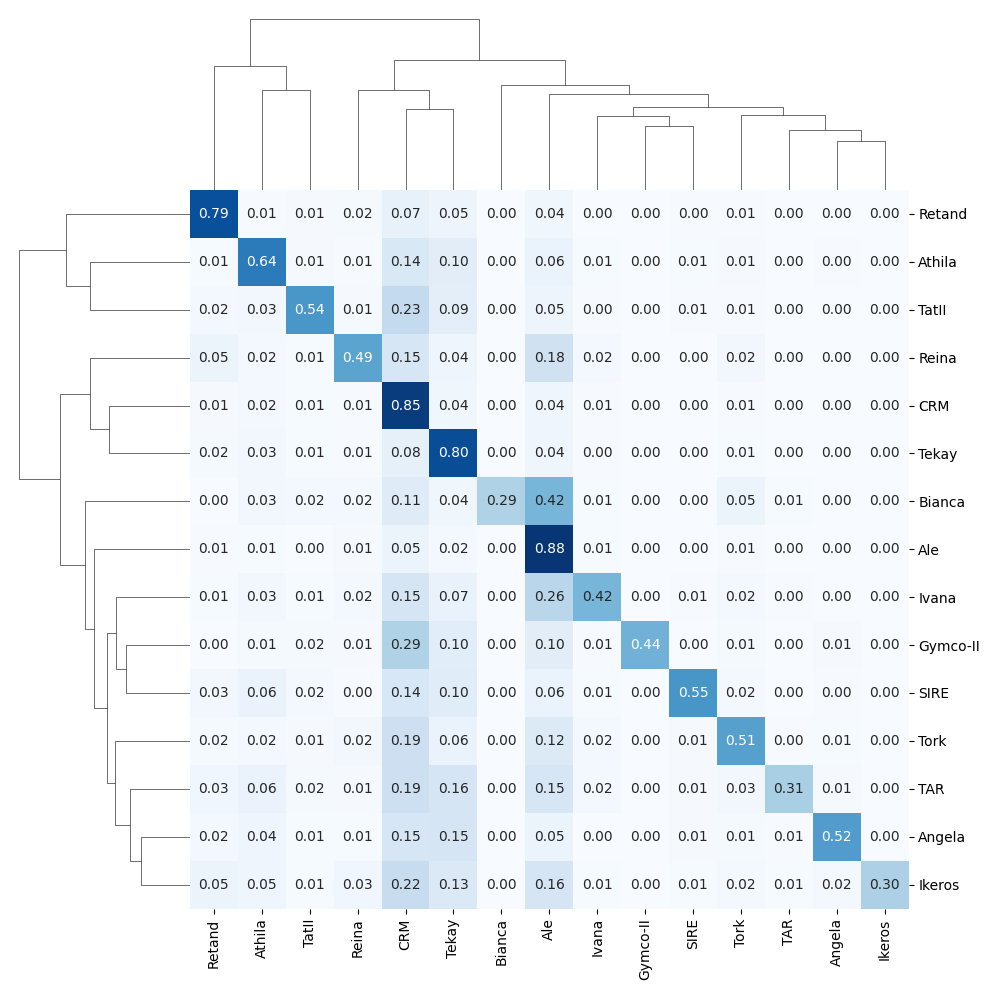

In [120]:
cm = confusion_matrix(Y_all, predicted_labels_GBC)
dt = pd.DataFrame(cm)
dt.columns = label_encoder.classes_
dt.index = label_encoder.classes_
dt_normalized = dt.div(dt.sum(axis=1), axis=0)

g = sns.clustermap(dt_normalized, row_linkage=linkage, col_linkage=linkage, annot=True, cmap="Blues", fmt=".2f", cbar=False, vmax=0.9, vmin=0)

g.cax.set_visible(False)
plt.savefig('GBC_lineage.svg', format='svg')

In [28]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")

iris = load_iris()
X, y = iris.data, iris.target
DF = pd.DataFrame(X, index = ["iris_%d" % (i) for i in range(X.shape[0])], columns = iris.feature_names)

DF_corr = DF.T.corr()
DF_dism = 1 - DF_corr   # distance matrix
linkage = hc.linkage(sp.distance.squareform(DF_dism), method='average')

In [ ]:
import pickle
le = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/label_encoder.b", "rb"))
le.classes_